### 核心目标
1.任务的空间复杂度（上传文件的上下文）降低到一个可以控制的范围
2.在完成基本任务的同时实现切片合并问题和输出格式的问题
### 做法
1.数据：使用docx这种可以编程解析的文件类型，
2.预处理:对文件整体解析，并对解析出来的文件段落进行组合作为单元任务上传(在上传前规划好这一次的token使用)
3.提示词：对于单元任务我们主要做的工作是概括并总结出这个单元围绕着什么来写，这个单元的实体之间有什么关系，为单元任务总结提示词，我们要给他上文提到的实体和关系，优化表现
4.结果整合：对于返回的json，进行数据库录入（知识图谱构建）

# 一、

In [2]:
from docx import Document
# from nltk.tokenize import word_tokenize
# import nltk

# nltk.download('punkt')  # 下载必要的数据，只需要运行一次
from http import HTTPStatus
from dashscope import Generation
from dashscope.api_entities.dashscope_response import Role

In [3]:
def count_tokens(paragraph):
    tokens = word_tokenize(paragraph)
    return len(tokens)

def read_paragraphs(file_path):
    doc = Document(file_path)

    paragraphs = []
    for paragraph in doc.paragraphs:
        paragraphs.append(paragraph.text)

    return paragraphs

def group_paragraphs_by_token_limit(file_path, token_limit):
    doc = Document(file_path)

    current_group = []
    total_tokens = 0
    groups = []

    for paragraph in doc.paragraphs:
        tokens_count = count_tokens(paragraph.text)

        if total_tokens + tokens_count > token_limit and current_group:
            # Start a new group when adding the current paragraph exceeds the token limit
            groups.append(current_group)
            current_group = []
            total_tokens = 0

        current_group.append(paragraph.text)
        total_tokens += tokens_count

    # Add the last group if it's not empty
    if current_group:
        groups.append(current_group)

    return groups

In [17]:
 # 指定.docx文件路径
docx_file_path = "./data/白皮书——幻觉.docx"

# 调用函数读取段落内容
# paragraphs = read_paragraphs(docx_file_path)
contents=group_paragraphs_by_token_limit(docx_file_path,600)
prompt = """
    在接下来的对话中，你需要遵循以下规则：
    你是一台用于处理文本数据的AI系统。你的任务是处理我上传的文本，并按照以下要求进行操作：
    - 输出标准JSON格式字符串,不需要输出换行符如"\"、"\n"等。
    - 剔除文件中的所有乱码（乱码不包括英文）。
    - 处理英文的时候 请保留英文的原格式，包括括号。
    - 对文本进行概括，形成json的abstract字段。
    - 对概括文本内知识点进行提取，并列成列表，形成json的point字段。
    - 有["从属","依赖","拓展","案例"]四种关系，对知识点与知识点之间的关系进行提取，有关系的知识点两两之间形成(知识点1,关系,知识点2)的元组，并以列表的形式存进json的edge字段
    - 格式参考示例:
    {
      "abstract": "(段落的概括)",
      "point": [
        "数学",
        "线性代数",
        "矩阵",
        "秩",
        "习题：矩阵的定义是什么",
        "线性代数提出者的一生"
      ],
      "edge":[
        ("线性代数","属于","数学"),
        ("矩阵","属于","线性代数"),
        ("秩","依赖","矩阵"),
        ("矩阵","案例","习题：矩阵的定义是什么"),
        ("线性代数","拓展","线性代数提出者的一生")
      ]
    }
    你不需要确认收到，或是做出过多解释，直接开始生成完整准确的输出。
"""
messages = [{'role': Role.SYSTEM, 'content': prompt},
            ]
for content_id,content in enumerate(contents):
    request=""
    for paragraph_id,paragraph in enumerate(content):
        request+=paragraph
        request+='\n'
    # messages.append({'role': Role.USER, 'content': request})
    messages = [{'role': Role.SYSTEM, 'content': prompt},
              {'role': Role.USER, 'content': request}]
    response = Generation.call(
        Generation.Models.qwen_max_longcontext,
        messages=messages,
        result_format='message',  # set the result to be "message" format.
    )
    if response.status_code == HTTPStatus.OK:
        print(response)
        # append result to messages.
        messages.append({'role': response.output.choices[0]['message']['role'],
                         'content': response.output.choices[0]['message']['content']})
    else:
        print('Request id: %s, Status code: %s, error code: %s, error message: %s' % (
            response.request_id, response.status_code,
            response.code, response.message
        ))

AttributeError: type object 'Models' has no attribute 'qwen_max_longcontext'

In [12]:
import json
# raw_string='''
# {\n  \"point\": [\n    \"大模型幻觉定义\",\n    \"事实性幻觉\",\n    \"忠实性幻觉\",\n    \"预训练阶段\",\n    \"SFT训练阶段\",\n    \"RLHF 训练阶段\",\n    \"生成推理阶段\",\n    \"缓解事实性幻觉\",\n    \"事实性数据增强\",\n    \"Honesty-oriented SFT\",\n    \"RHLF\",\n    \"对比解码（Contrastive decoding）\",\n    \"DoLa：对比层解码提高了大型语言模型的真实性\",\n    \"缓解忠实性幻觉\",\n    \"思维链（COT）\",\n    \"上下文预训练（In-Context Pretraining）\",\n    \"检索增强（RAG）\",\n    \"自然语言推理链（CoNLI）\",\n    \"知识约束解码（KCD）\"\n  ],\n  \"edge\": [\n    [\"大模型幻觉定义\", \"属于\", \"金融大模型幻觉问题\"],\n    [\"事实性幻觉\", \"属于\", \"大模型幻觉定义\"],\n    [\"忠实性幻觉\", \"属于\", \"大模型幻觉定义\"],\n    [\"预训练阶段\", \"属于\", \"大模型幻觉的来源\"],\n    [\"SFT训练阶段\", \"属于\", \"大模型幻觉的来源\"],\n    [\"RLHF 训练阶段\", \"属于\", \"大模型幻觉的来源\"],\n    [\"生成推理阶段\", \"属于\", \"大模型幻觉的来源\"],\n    [\"缓解事实性幻觉\", \"属于\", \"缓解幻觉的方法\"],\n    [\"事实性数据增强\", \"属于\", \"缓解事实性幻觉\"],\n    [\"Honesty-oriented SFT\", \"属于\", \"缓解事实性幻觉\"],\n    [\"RHLF\", \"属于\", \"缓解事实性幻觉\"],\n    [\"对比解码（Contrastive decoding）\", \"属于\", \"缓解事实性幻觉\"],\n    [\"DoLa：对比层解码提高了大型语言模型的真实性\", \"属于\", \"缓解事实性幻觉\"],\n    [\"缓解忠实性幻觉\", \"属于\", \"缓解幻觉的方法\"],\n    [\"思维链（COT）\", \"属于\", \"缓解忠实性幻觉\"],\n    [\"上下文预训练（In-Context Pretraining）\", \"属于\", \"缓解忠实性幻觉\"],\n    [\"检索增强（RAG）\", \"属于\", \"缓解忠实性幻觉\"],\n    [\"自然语言推理链（CoNLI）\", \"属于\", \"缓解忠实性幻觉\"],\n    [\"知识约束解码（KCD）\", \"属于\", \"缓解忠实性幻觉\"]\n  ]\n}
# '''
raw_string='''
{ \"point\": [ \"大模型幻觉\", \"幻觉问题\", \"金融应用\", \"预训练阶段\", \"SFT训练阶段\", \"RLHF 训练阶段\", \"生成推理阶段\", \"数据缺陷\", \"低效的数据利用方式\", \"指令不一致\", \"上下文不一致\", \"过度自信\", \"错误的对齐过程\", \"解码方式的缺陷\", \"事实性幻觉\", \"忠实性幻觉\", \"事实性数据增强\", \"Honesty-oriented SFT\", \"RHLF\", \"对比解码\", \"DoLa\", \"思维链(COT)\", \"上下文预训练\", \"检索增强(RAG)\", \"自然语言推理链(CoNLI)\", \"知识约束解码(KCD)\" ], \"edge\": [ [\"大模型幻觉\",\"金融应用\",\"属于\"], [\"预训练阶段\",\"大模型幻觉\",\"属于\"], [\"SFT训练阶段\",\"大模型幻觉\",\"属于\"], [\"RLHF 训练阶段\",\"大模型幻觉\",\"属于\"], [\"生成推理阶段\",\"大模型幻觉\",\"属于\"], [\"数据缺陷\",\"预训练阶段\",\"关联\"], [\"低效的数据利用方式\",\"预训练阶段\",\"关联\"], [\"指令不一致\",\"SFT训练阶段\",\"关联\"], [\"上下文不一致\",\"SFT训练阶段\",\"关联\"], [\"过度自信\",\"RLHF 训练阶段\",\"关联\"], [\"错误的对齐过程\",\"RLHF 训练阶段\",\"关联\"], [\"解码方式的缺陷\",\"生成推理阶段\",\"关联\"], [\"事实性幻觉\",\"大模型幻觉\",\"递进\"], [\"忠实性幻觉\",\"大模型幻觉\",\"递进\"], [\"事实性数据增强\",\"事实性幻觉\",\"缓解方法\"], [\"Honesty-oriented SFT\",\"事实性幻觉\",\"缓解方法\"], [\"RHLF\",\"事实性幻觉\",\"缓解方法\"], [\"对比解码\",\"事实性幻觉\",\"缓解方法\"], [\"DoLa\",\"事实性幻觉\",\"缓解方法\"], [\"思维链(COT)\",\"忠实性幻觉\",\"缓解方法\"], [\"上下文预训练\",\"忠实性幻觉\",\"缓解方法\"], [\"检索增强(RAG)\",\"忠实性幻觉\",\"缓解方法\"], [\"自然语言推理链(CoNLI)\",\"忠实性幻觉\",\"缓解方法\"], [\"知识约束解码(KCD)\",\"忠实性幻觉\",\"缓解方法\"] ] }
'''
# 解码为字符串
decoded_string = raw_string

# 去除字符串内部的"\\"和"\\n"
cleaned_string = decoded_string.replace("\\", "").replace("\\n", "").replace("```","").replace("json","")

# 尝试解析为JSON
try:
    json_data = json.loads(cleaned_string)
    point=json_data["point"]
    edge=json_data["edge"]
    # print(json.dumps(json_data, indent=2, ensure_ascii=False))  # 打印格式化后的JSON
    print(point)
    print(edge)
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")

['大模型幻觉', '幻觉问题', '金融应用', '预训练阶段', 'SFT训练阶段', 'RLHF 训练阶段', '生成推理阶段', '数据缺陷', '低效的数据利用方式', '指令不一致', '上下文不一致', '过度自信', '错误的对齐过程', '解码方式的缺陷', '事实性幻觉', '忠实性幻觉', '事实性数据增强', 'Honesty-oriented SFT', 'RHLF', '对比解码', 'DoLa', '思维链(COT)', '上下文预训练', '检索增强(RAG)', '自然语言推理链(CoNLI)', '知识约束解码(KCD)']
[['大模型幻觉', '金融应用', '属于'], ['预训练阶段', '大模型幻觉', '属于'], ['SFT训练阶段', '大模型幻觉', '属于'], ['RLHF 训练阶段', '大模型幻觉', '属于'], ['生成推理阶段', '大模型幻觉', '属于'], ['数据缺陷', '预训练阶段', '关联'], ['低效的数据利用方式', '预训练阶段', '关联'], ['指令不一致', 'SFT训练阶段', '关联'], ['上下文不一致', 'SFT训练阶段', '关联'], ['过度自信', 'RLHF 训练阶段', '关联'], ['错误的对齐过程', 'RLHF 训练阶段', '关联'], ['解码方式的缺陷', '生成推理阶段', '关联'], ['事实性幻觉', '大模型幻觉', '递进'], ['忠实性幻觉', '大模型幻觉', '递进'], ['事实性数据增强', '事实性幻觉', '缓解方法'], ['Honesty-oriented SFT', '事实性幻觉', '缓解方法'], ['RHLF', '事实性幻觉', '缓解方法'], ['对比解码', '事实性幻觉', '缓解方法'], ['DoLa', '事实性幻觉', '缓解方法'], ['思维链(COT)', '忠实性幻觉', '缓解方法'], ['上下文预训练', '忠实性幻觉', '缓解方法'], ['检索增强(RAG)', '忠实性幻觉', '缓解方法'], ['自然语言推理链(CoNLI)', '忠实性幻觉', '缓解方法'], ['知识约束解码(KCD)', '忠实性幻觉', '缓解方法']]


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# 创建一个有向图
G = nx.DiGraph()

# 添加节点
for item in edge:
    G.add_node(item)

# 添加边
G.add_edge("Python", "Data Science")
G.add_edge("Data Science", "Machine Learning")
G.add_edge("Machine Learning", "Deep Learning")

# 绘制图谱
pos = nx.spring_layout(G)  # 使用弹簧布局算法排列节点
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=1500, node_color="skyblue", arrowsize=20)

# 显示图谱
plt.show()

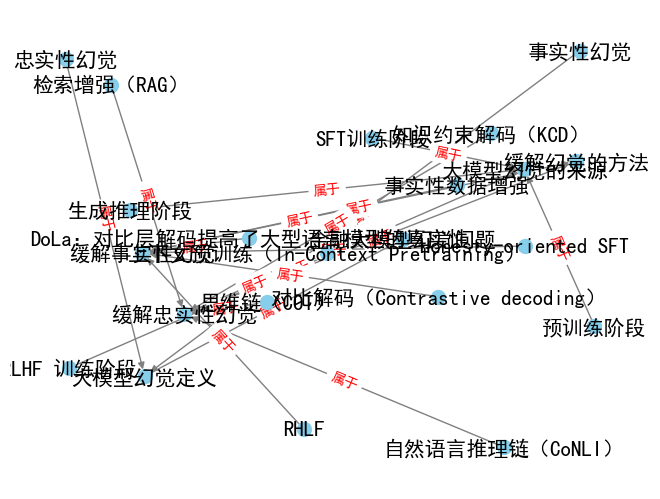

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

import json
raw_string='''
{\n  \"point\": [\n    \"大模型幻觉定义\",\n    \"事实性幻觉\",\n    \"忠实性幻觉\",\n    \"预训练阶段\",\n    \"SFT训练阶段\",\n    \"RLHF 训练阶段\",\n    \"生成推理阶段\",\n    \"缓解事实性幻觉\",\n    \"事实性数据增强\",\n    \"Honesty-oriented SFT\",\n    \"RHLF\",\n    \"对比解码（Contrastive decoding）\",\n    \"DoLa：对比层解码提高了大型语言模型的真实性\",\n    \"缓解忠实性幻觉\",\n    \"思维链（COT）\",\n    \"上下文预训练（In-Context Pretraining）\",\n    \"检索增强（RAG）\",\n    \"自然语言推理链（CoNLI）\",\n    \"知识约束解码（KCD）\"\n  ],\n  \"edge\": [\n    [\"大模型幻觉定义\", \"属于\", \"金融大模型幻觉问题\"],\n    [\"事实性幻觉\", \"属于\", \"大模型幻觉定义\"],\n    [\"忠实性幻觉\", \"属于\", \"大模型幻觉定义\"],\n    [\"预训练阶段\", \"属于\", \"大模型幻觉的来源\"],\n    [\"SFT训练阶段\", \"属于\", \"大模型幻觉的来源\"],\n    [\"RLHF 训练阶段\", \"属于\", \"大模型幻觉的来源\"],\n    [\"生成推理阶段\", \"属于\", \"大模型幻觉的来源\"],\n    [\"缓解事实性幻觉\", \"属于\", \"缓解幻觉的方法\"],\n    [\"事实性数据增强\", \"属于\", \"缓解事实性幻觉\"],\n    [\"Honesty-oriented SFT\", \"属于\", \"缓解事实性幻觉\"],\n    [\"RHLF\", \"属于\", \"缓解事实性幻觉\"],\n    [\"对比解码（Contrastive decoding）\", \"属于\", \"缓解事实性幻觉\"],\n    [\"DoLa：对比层解码提高了大型语言模型的真实性\", \"属于\", \"缓解事实性幻觉\"],\n    [\"缓解忠实性幻觉\", \"属于\", \"缓解幻觉的方法\"],\n    [\"思维链（COT）\", \"属于\", \"缓解忠实性幻觉\"],\n    [\"上下文预训练（In-Context Pretraining）\", \"属于\", \"缓解忠实性幻觉\"],\n    [\"检索增强（RAG）\", \"属于\", \"缓解忠实性幻觉\"],\n    [\"自然语言推理链（CoNLI）\", \"属于\", \"缓解忠实性幻觉\"],\n    [\"知识约束解码（KCD）\", \"属于\", \"缓解忠实性幻觉\"]\n  ]\n}
'''
# 解码为字符串
decoded_string = raw_string.encode('utf-8').decode('utf-8')

# 去除字符串内部的"\\"和"\\n"
cleaned_string = decoded_string.replace("\\", "").replace("\\n", "")


# 尝试解析为JSON
try:
    json_data = json.loads(cleaned_string)
    nodes=json_data["point"]
    edges=json_data["edge"]
    # print(json.dumps(json_data, indent=2, ensure_ascii=False))  # 打印格式化后的JSON
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
# 创建一个有向图对象
G = nx.DiGraph()
edges = [(u, v, {'relation': r}) for u, r, v in edges]
# 添加节点和边到图中
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# 绘制图形
pos = nx.random_layout(G)  # 选择布局算法
# edge_labels = {(u, v): r for u, r, v in G.edges(data=False)}
edge_labels = {(u, v): d['relation'] for u, v, d in G.edges(data=True)}
# 设置节点大小
node_size = 100
plt.rcParams['font.sans-serif'] = 'SimHei'
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=node_size, node_color='skyblue', font_size=15, edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5, font_color='red')

# 显示图形
plt.show()

In [28]:
import networkx as nx
import matplotlib.pyplot as plt

import json
raw_string='''
{\n  \"point\": [\n    \"大模型幻觉定义\",\n    \"事实性幻觉\",\n    \"忠实性幻觉\",\n    \"预训练阶段\",\n    \"SFT训练阶段\",\n    \"RLHF 训练阶段\",\n    \"生成推理阶段\",\n    \"缓解事实性幻觉\",\n    \"事实性数据增强\",\n    \"Honesty-oriented SFT\",\n    \"RHLF\",\n    \"对比解码（Contrastive decoding）\",\n    \"DoLa：对比层解码提高了大型语言模型的真实性\",\n    \"缓解忠实性幻觉\",\n    \"思维链（COT）\",\n    \"上下文预训练（In-Context Pretraining）\",\n    \"检索增强（RAG）\",\n    \"自然语言推理链（CoNLI）\",\n    \"知识约束解码（KCD）\"\n  ],\n  \"edge\": [\n    [\"大模型幻觉定义\", \"属于\", \"金融大模型幻觉问题\"],\n    [\"事实性幻觉\", \"属于\", \"大模型幻觉定义\"],\n    [\"忠实性幻觉\", \"属于\", \"大模型幻觉定义\"],\n    [\"预训练阶段\", \"属于\", \"大模型幻觉的来源\"],\n    [\"SFT训练阶段\", \"属于\", \"大模型幻觉的来源\"],\n    [\"RLHF 训练阶段\", \"属于\", \"大模型幻觉的来源\"],\n    [\"生成推理阶段\", \"属于\", \"大模型幻觉的来源\"],\n    [\"缓解事实性幻觉\", \"属于\", \"缓解幻觉的方法\"],\n    [\"事实性数据增强\", \"属于\", \"缓解事实性幻觉\"],\n    [\"Honesty-oriented SFT\", \"属于\", \"缓解事实性幻觉\"],\n    [\"RHLF\", \"属于\", \"缓解事实性幻觉\"],\n    [\"对比解码（Contrastive decoding）\", \"属于\", \"缓解事实性幻觉\"],\n    [\"DoLa：对比层解码提高了大型语言模型的真实性\", \"属于\", \"缓解事实性幻觉\"],\n    [\"缓解忠实性幻觉\", \"属于\", \"缓解幻觉的方法\"],\n    [\"思维链（COT）\", \"属于\", \"缓解忠实性幻觉\"],\n    [\"上下文预训练（In-Context Pretraining）\", \"属于\", \"缓解忠实性幻觉\"],\n    [\"检索增强（RAG）\", \"属于\", \"缓解忠实性幻觉\"],\n    [\"自然语言推理链（CoNLI）\", \"属于\", \"缓解忠实性幻觉\"],\n    [\"知识约束解码（KCD）\", \"属于\", \"缓解忠实性幻觉\"]\n  ]\n}
'''
# 解码为字符串
decoded_string = raw_string.encode('utf-8').decode('utf-8')

# 去除字符串内部的"\\"和"\\n"
cleaned_string = decoded_string.replace("\\", "").replace("\\n", "")


# 尝试解析为JSON
try:
    json_data = json.loads(cleaned_string)
    nodes_array=json_data["point"]
    edges_array=json_data["edge"]
    # print(json.dumps(json_data, indent=2, ensure_ascii=False))  # 打印格式化后的JSON
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")

import xmind
from xmind.core.topic import TopicElement

def create_nodes_and_edges(node_array, edge_array, parent_topic=None):
    # 创建一个空的XMind文件
    workbook = xmind.load("empty.xmind")

    # 如果没有指定父主题，创建一个新的根主题
    if parent_topic is None:
        sheet = workbook.getPrimarySheet()
        parent_topic = sheet.getRootTopic()
        parent_topic.setTitle("大模型幻觉")

    # 创建节点
    nodes = {}
    for node_data in node_array:
        node_topic = TopicElement(ownerWorkbook=workbook)
        node_topic.setTitle(node_data)
        nodes[node_data] = node_topic
        parent_topic.addSubTopic(node_topic)
    # 创建边
    for edge in edge_array:
        u,r,v = edge
        if u in nodes and v in nodes:
            workbook.createRelationship(nodes[u], nodes[v],r) 
            
    # 保存XMind文件
    xmind.save(workbook, "knowledge_graph_from_arrays.xmind")

if __name__ == "__main__":
    # 示例节点数组和边数组

    # 从数组中创建节点和边
    create_nodes_and_edges(nodes_array, edges_array)


In [27]:
import networkx as nx
import matplotlib.pyplot as plt

import json
raw_string='''
{
    "point": [
        "大模型幻觉定义",
        "事实性幻觉",
        "忠实性幻觉",
        "预训练阶段",
        "SFT训练阶段",
        "RLHF 训练阶段",
        "生成推理阶段",
        "缓解事实性幻觉",
        "事实性数据增强",
        "Honesty-oriented SFT",
        "RHLF",
        "对比解码",
        "DoLa：对比层解码提高了大型语言模型的真实性",
        "缓解忠实性幻觉",
        "思维链",
        "上下文预训练",
        "检索增强",
        "自然语言推理链",
        "知识约束解码"
    ],
    "edge": [
        ["大模型幻觉定义", "属于", "金融"],
        ["事实性幻觉", "属于", "大模型幻觉定义"],
        ["忠实性幻觉", "属于", "大模型幻觉定义"],
        ["预训练阶段", "属于", "大模型幻觉来源"],
        ["SFT训练阶段", "属于", "大模型幻觉来源"],
        ["RLHF 训练阶段", "属于", "大模型幻觉来源"],
        ["生成推理阶段", "属于", "大模型幻觉来源"],
        ["缓解事实性幻觉", "递进", "大模型幻觉问题"],
        ["事实性数据增强", "属于", "缓解事实性幻觉"],
        ["Honesty-oriented SFT", "属于", "缓解事实性幻觉"],
        ["RHLF", "属于", "缓解事实性幻觉"],
        ["对比解码", "属于", "缓解事实性幻觉"],
        ["DoLa：对比层解码提高了大型语言模型的真实性", "属于", "缓解事实性幻觉"],
        ["缓解忠实性幻觉", "递进", "大模型幻觉问题"],
        ["思维链", "属于", "缓解忠实性幻觉"],
        ["上下文预训练", "属于", "缓解忠实性幻觉"],
        ["检索增强", "属于", "缓解忠实性幻觉"],
        ["自然语言推理链", "属于", "缓解忠实性幻觉"],
        ["知识约束解码", "属于", "缓解忠实性幻觉"]
    ]
}
'''
# 解码为字符串
decoded_string = raw_string.encode('utf-8').decode('utf-8')

# 去除字符串内部的"\\"和"\\n"
cleaned_string = decoded_string.replace("\\", "").replace("\\n", "")


# 尝试解析为JSON
try:
    json_data = json.loads(cleaned_string)
    nodes_array=json_data["point"]
    edges_array=[tuple(sublist) for sublist in json_data["edge"]]
    print(nodes_array)
    print(edges_array)
    # print(json.dumps(json_data, indent=2, ensure_ascii=False))  # 打印格式化后的JSON
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")

['大模型幻觉定义', '事实性幻觉', '忠实性幻觉', '预训练阶段', 'SFT训练阶段', 'RLHF 训练阶段', '生成推理阶段', '缓解事实性幻觉', '事实性数据增强', 'Honesty-oriented SFT', 'RHLF', '对比解码', 'DoLa：对比层解码提高了大型语言模型的真实性', '缓解忠实性幻觉', '思维链', '上下文预训练', '检索增强', '自然语言推理链', '知识约束解码']
[('大模型幻觉定义', '属于', '金融'), ('事实性幻觉', '属于', '大模型幻觉定义'), ('忠实性幻觉', '属于', '大模型幻觉定义'), ('预训练阶段', '属于', '大模型幻觉来源'), ('SFT训练阶段', '属于', '大模型幻觉来源'), ('RLHF 训练阶段', '属于', '大模型幻觉来源'), ('生成推理阶段', '属于', '大模型幻觉来源'), ('缓解事实性幻觉', '递进', '大模型幻觉问题'), ('事实性数据增强', '属于', '缓解事实性幻觉'), ('Honesty-oriented SFT', '属于', '缓解事实性幻觉'), ('RHLF', '属于', '缓解事实性幻觉'), ('对比解码', '属于', '缓解事实性幻觉'), ('DoLa：对比层解码提高了大型语言模型的真实性', '属于', '缓解事实性幻觉'), ('缓解忠实性幻觉', '递进', '大模型幻觉问题'), ('思维链', '属于', '缓解忠实性幻觉'), ('上下文预训练', '属于', '缓解忠实性幻觉'), ('检索增强', '属于', '缓解忠实性幻觉'), ('自然语言推理链', '属于', '缓解忠实性幻觉'), ('知识约束解码', '属于', '缓解忠实性幻觉')]


In [35]:
import xmind
from xmind.core.topic import TopicElement
from xmind.core.const import TOPIC_DETACHED
workbook = xmind.load("empty.xmind")
sheet = workbook.getPrimarySheet()
class Node:
    def __init__(self, name):
        self.name = name
        self.node_topic = TopicElement(ownerWorkbook=workbook)
        self.node_topic.setTitle(name)

class Edge:
    def __init__(self, source, relation, target):
        self.source = source
        self.relation = relation
        self.target = target
        if relation=="属于":
            target.node_topic.addSubTopic(source.node_topic)
        else:
            target.node_topic.addSubTopic(source.node_topic)
            sheet.createRelationship(source.node_topic, target.node_topic, relation) 
class Forest:
    def __init__(self):
        self.nodes = []
        self.edges = []

    def add_node(self, node):
        self.nodes.append(node)

    def add_edge(self, edge):
        self.edges.append(edge)

    def build_forest(self, nodes, edges):
        for node_name in nodes:
            node = Node(node_name)
            self.add_node(node)

        for edge_data in edges:
            source_name, relation, target_name = edge_data
            source_node = next((node for node in self.nodes if node.name == source_name), None)
            target_node = next((node for node in self.nodes if node.name == target_name), None)

            if not source_node:
                source_node = Node(source_name)
                self.add_node(source_node)

            if not target_node:
                target_node = Node(target_name)
                self.add_node(target_node)

            edge = Edge(source_node, relation, target_node)
            self.add_edge(edge)
    def get_tree_roots(self):
        roots = [node for node in self.nodes if all(edge.source != node for edge in self.edges)]
        return roots
    def build_kg(self,topic=None):
        parent_topic = sheet.getRootTopic()
        if topic:
            parent_topic.setTitle(topic)
            name=topic+".xmind"
        else:
            parent_topic.setTitle("知识图谱")
            name="知识图谱.xmind"
        tree_roots = self.get_tree_roots()
        for root in tree_roots:
            print(f"树的头节点: {root.name}")
            parent_topic.addSubTopic(root.node_topic)
        xmind.save(workbook, name)

In [36]:
forest = Forest()
forest.build_forest(nodes_array, edges_array)

In [37]:
forest.build_kg()

树的头节点: 金融
树的头节点: 大模型幻觉来源
树的头节点: 大模型幻觉问题


In [34]:
from docx import Document
file_path = "./data/（153）商业智能在电子商务中的实践与应用-黄建鹏、徐晓冬、魏宝军-东南大学出版社.docx"
document = Document(file_path)
sections = document.sections
len(sections)


73